# Capstone Project
This Jupyter Notebook is used for the Applied Data Science Capstone Course on Coursera
<br>
***

Import the necessary libraries

In [84]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopy
import folium
import requests
import progressbar
import time
import sklearn.cluster
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from unicodedata import normalize
from collections import Counter

***
## Postal code data

Read the database for the postal codes in Brazil

In [2]:
fileName = 'BR-PostalCodes(CEPs).txt'
postalBR_df = pd.read_csv(fileName, sep='\\t', names=['Postal Code','City','Neighborhood','Address','Near'], encoding='utf-8', converters={'Postal Code': lambda x: str(x)})
postalBR_df.head()

<ipython-input-2-dfd5f45049c7>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  postalBR_df = pd.read_csv(fileName, sep='\\t', names=['Postal Code','City','Neighborhood','Address','Near'], encoding='utf-8', converters={'Postal Code': lambda x: str(x)})


,Postal Code,City,Neighborhood,Address,Near
0,01001000,São Paulo/SP,Sé,Praça da Sé - lado ímpar,None
1,01001001,São Paulo/SP,Sé,Praça da Sé - lado par,None
2,01001010,São Paulo/SP,Sé,Rua Filipe de Oliveira,None
3,01001900,São Paulo/SP,Sé,"Praça da Sé, 108",UNESP - Universidade Estadual Júlio de Mesqui...
4,01001901,São Paulo/SP,Sé,"Praça da Sé, 371",Edifício Santa Lídia


Filter to obtain only the postal codes in São Paulo city

In [3]:
postalSP_df = postalBR_df[postalBR_df['City'] == 'São Paulo/SP']
postalSP_df.drop_duplicates(subset=['Neighborhood'], inplace=True) # Only keeping one postal code for each neighborhood
postalSP_df.reset_index(inplace=True)
postalSP_df.drop(['index','City','Address','Near'], axis=1, inplace=True) # Dropping unnecessary columns

print('Before the filter: %d ocurrences.\nAfter the filter %d ocurrences.' % (postalBR_df.shape[0], postalSP_df.shape[0]))
postalSP_df.head()

Before the filter: 732763 ocurrences.
After the filter 1907 ocurrences.


<ipython-input-3-304d5290f37f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postalSP_df.drop_duplicates(subset=['Neighborhood'], inplace=True) # Only keeping one postal code for each neighborhood
c:\users\labore06.desktop-lrohkpv\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Postal Code,Neighborhood
0,01001000,Sé
1,01002020,Centro
2,01017000,Brás
3,01035100,República
4,01101000,Luz


Correcting the postal codes to correspond to the correct format for searching

In [4]:
def correctPostalCode(postalCode):
    return postalCode[:5] + '-' + postalCode[5:]

postalSP_df['Postal Code'] = postalSP_df['Postal Code'].apply(correctPostalCode)
postalSP_df.set_index('Postal Code', inplace=True)

postalSP_df.head()

<ipython-input-4-4d27804cb7f4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postalSP_df['Postal Code'] = postalSP_df['Postal Code'].apply(correctPostalCode)


,Neighborhood
Postal Code,
01001-000,Sé
01002-020,Centro
01017-000,Brás
01035-100,República
01101-000,Luz


Searching for the latitude and longitude for each postal code<br>
***WARNING:*** This will take several minutes

In [6]:
print('Obtaining latitude and longitude for the postal codes:')
latitudes = []
longitudes = []
postalCodes = []

geolocator = geopy.geocoders.Nominatim(user_agent="sp_explorer")
geopy.geocoders.options.default_timeout = 100

bar = progressbar.ProgressBar(maxval=postalSP_df.shape[0], 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

for i, postalCode in enumerate(postalSP_df.index):
    geoData = geolocator.geocode(postalCode)
    
    postalCodes.append(postalCode)
    try:
        latitudes.append(geoData.latitude)
    except:
        latitudes.append(np.nan) # if the geolocator could not retrieve the data from the provided postal code, then put a placeholder NaN
    try:
        longitudes.append(geoData.longitude)
    except:
        longitudes.append(np.nan) # if the geolocator could not retrieve the data from the provided postal code, then put a placeholder NaN
    
    time.sleep(1) # wait for 1 sec in order to conform to the nominatim usage policy
    bar.update(i)

bar.finish()

lat_long_df = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes}, postalCodes)
lat_long_df.index.name = 'Postal Code'

lat_long_df.head()

Obtaining latitude and longitude for the postal codes:


[========================================================================] 100%


,Latitude,Longitude
Postal Code,,
01001-000,-23.550562,-46.633653
01002-020,-23.547212,-46.637019
01017-000,-23.549744,-46.631144
01035-100,-23.540726,-46.643465
01101-000,-23.522819,-46.630261


Merging into a single dataframe containing the neighborhoods and lat,lng

In [7]:
postalLatLng_df = pd.concat([postalSP_df, lat_long_df], axis=1)
postalLatLng_df.dropna(inplace=True) # eliminate NaN entries
print('Before the cleanup: %d ocurrences.\nAfter the cleanup %d ocurrences.\nThus, the geocoder was unable to get the data for %d entries.' % (postalSP_df.shape[0], postalLatLng_df.shape[0], postalSP_df.shape[0]-postalLatLng_df.shape[0]))

Before the cleanup: 1907 ocurrences.
After the cleanup 948 ocurrences.
Thus, the geocoder was unable to get the data for 959 entries.


Visualize each neighborhood in the map

In [8]:
geoData = geolocator.geocode('São Paulo, SP')

map_SP = folium.Map(
    location=[
        geoData.latitude,
        geoData.longitude
    ], 
    zoom_start=10)

# add markers to map
for lat, lng, label in zip(postalLatLng_df['Latitude'], postalLatLng_df['Longitude'], postalLatLng_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SP)

display(map_SP)

***
## Immigration data

Scrape the wiki page to get the immigrants from each São Paulo neighborhood<br>
***Note:*** The page is in portuguese

In [9]:
url = 'https://pt.wikipedia.org/wiki/Lista_dos_bairros_paulistanos_por_imigra%C3%A7%C3%A3o' # Define the URL to get the data from
immigrantHTML = requests.get(url) # Get the data
immigrantSoup = BeautifulSoup(immigrantHTML.text, 'html.parser') # Get the soup

immigrantTables = immigrantSoup.findAll('table') # Find the tables inside the soup

Convert to a pandas dataframe

In [10]:
immigrant_df_orig = pd.read_html(str(immigrantTables),header=0)[4] # immigrants from America
immigrant_df_orig = immigrant_df_orig.append(pd.read_html(str(immigrantTables),header=0)[7], ignore_index=True) # append immigrants from Europe
immigrant_df_orig = immigrant_df_orig.append(pd.read_html(str(immigrantTables),header=0)[10], ignore_index=True) # append immigrants from Asia
immigrant_df_orig = immigrant_df_orig.append(pd.read_html(str(immigrantTables),header=0)[12], ignore_index=True) # append immigrants from Africa
immigrant_df_orig = immigrant_df_orig.append(pd.read_html(str(immigrantTables),header=0)[14], ignore_index=True) # append migrants from Brazil

# Correct the column names
immigrant_df_orig['País'][immigrant_df_orig['País'].isnull()] = immigrant_df_orig['País/Região'][immigrant_df_orig['País'].isnull()]
immigrant_df_orig['País'][immigrant_df_orig['País'].isnull()] = immigrant_df_orig['País/Origem'][immigrant_df_orig['País'].isnull()]
immigrant_df_orig['País'][immigrant_df_orig['País'].isnull()] = immigrant_df_orig['Origem'][immigrant_df_orig['País'].isnull()]
immigrant_df_orig.drop(['País/Região', 'País/Origem', 'Origem', 'Região'], axis=1, inplace=True)

# Eliminate brackets from wiki table
immigrant_df_orig['Bairro'].replace(regex='\[\\d*\]*', value='', inplace=True)

immigrant_df_orig.head()

,País,Bairro
0,Argentina,Bom Retiro
1,Argentina,Brás
2,Argentina,Cerqueira César
3,Argentina,Jardim América
4,Argentina,Jardim Paulista


Translation to English

In [11]:
immigrant_df_orig.columns = ['Origin', 'Neighborhood']

pt_eng_dict = {'Argentina': 'Argentina',
               'Bolívia': 'Bolivia',
               'Canadá': 'Canada',
               'Colômbia': 'Colombia',
               'Equador': 'Ecuador',
               'Haiti': 'Haiti',
               'Estados Unidos': 'United States',
               'Paraguai': 'Paraguay',
               'Peru': 'Peru',
               'Uruguai': 'Uruguay',
               'Venezuela': 'Venezuela',
               'Alemanha': 'Germany',
               'Armênia': 'Armenia',
               'Áustria': 'Austria',
               'Bélgica': 'Belgium',
               'Bielorrússia': 'Belarus',
               'Bulgária': 'Bulgaria',
               'Catalunha': 'Spain',
               'Croácia': 'Croatia',
               'Escócia': 'Scotland',
               'Eslováquia': 'Slovakia',
               'Eslovênia': 'Slovenia',
               'Espanha': 'Spain',
               'Estónia': 'Estonia',
               'França': 'France',
               'Grécia': 'Greece',
               'Hungria': 'Hungary',
               'Império Austro-Hungaro': 'Austria, Hungary, Czech Republic, Slovakia, Poland, Ukraine, Romania, Italy, Bulgaria',
               'Inglaterra': 'England',
               'Irlanda': 'Ireland',
               'Itália': 'Italy',
               'Letônia': 'Latvia',
               'Lituânia': 'Lithuania',
               'Noruega': 'Norway',
               'Países Baixos': 'Netherlands',
               'Polónia': 'Poland',
               'Portugal': 'Portugal',
               'Chéquia': 'Czechia',
               'Roménia': 'Romania',
               'Rússia': 'Russia',
               'Suécia': 'Sweden',
               'Suíça': 'Switzerland',
               'Ucrânia': 'Ukraine',
               'Judeus': 'Israel',
               'Judeus marranos': 'Israel',
               'Arábia Saudita': 'Saudi Arabia',
               'China': 'China',
               'Coreia do Sul': 'South Korea',
               'Israel': 'Israel',
               'Japão': 'Japan',
               'Síria e Líbano': 'Syria, Lebanon',
               'Taiwan': 'Taiwan',
               'Iêmen': 'Yemen',
               'Angola': 'Angola',
               'Egito': 'Egypt',
               'Marrocos': 'Morocco',
               'Nigéria': 'Nigeria',
               'Senegal': 'Senegal',
               'Fluminenses': 'Brazil-Fluminenses',
               'Nordestinos': 'Brazil-Northeast'}

immigrant_df_orig.replace({'Origin': pt_eng_dict}, inplace=True)

immigrant_df_orig.head()

,Origin,Neighborhood
0,Argentina,Bom Retiro
1,Argentina,Brás
2,Argentina,Cerqueira César
3,Argentina,Jardim América
4,Argentina,Jardim Paulista


Word cloud

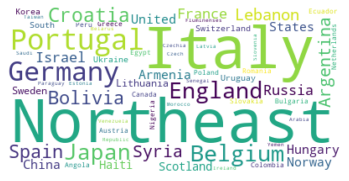

In [12]:
neighSP_wc = WordCloud(
    background_color='white',
    max_words=2000,
    collocations=False,
    stopwords=['Brazil']
)

neighSP_wc.generate(','.join(immigrant_df_orig['Origin']))

plt.imshow(neighSP_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Grouping by neighborhood

In [13]:
immigrant_df = immigrant_df_orig.groupby(['Neighborhood'])['Origin'].apply(', '.join).reset_index()

print('There are %d neighborhoods in the dataset.' % (immigrant_df.shape[0]))
immigrant_df.head()

There are 139 neighborhoods in the dataset.


,Neighborhood,Origin
0,Aclimação,South Korea
1,Alto da Boa Vista,"Germany, Belgium, England"
2,Alto da Lapa,Hungary
3,Alto da Mooca,"Croatia, Italy"
4,Alto de Pinheiros,"United States, Germany, Austria, Switzerland"


***
## Combine the postal code data (with lat,lng) and the immigration data

In [14]:
postalLatLng_df.sort_values(by='Neighborhood', inplace=True)

merged_df_orig = pd.concat([postalLatLng_df.reset_index().set_index('Neighborhood'), 
                            immigrant_df.set_index('Neighborhood')], 
                           axis=1)

merged_df = merged_df_orig.dropna() # eliminate NaN entries

print('The merged dataset originally had %d entries, which was reduced to %d after the cleanup' % (merged_df_orig.shape[0], merged_df.shape[0]))
merged_df.head()

The merged dataset originally had 1027 entries, which was reduced to 60 after the cleanup


,Postal Code,Latitude,Longitude,Origin
Aclimação,01526-000,37.495468,-88.418574,South Korea
Alto da Boa Vista,04713-000,49.258407,17.063654,"Germany, Belgium, England"
Barra Funda,01134-901,49.934256,18.008503,"Italy, Brazil-Northeast"
Bela Vista,01306-000,-23.550873,-46.646718,"United States, Belgium, Scotland, England, Ita..."
Belenzinho,03014-040,50.059600,14.095236,Italy


Visualize the remaining neighborhoods in the map

In [15]:
map_SP = folium.Map(
    location=[
        geoData.latitude,
        geoData.longitude
    ], 
    zoom_start=11)

# add markers to map
for lat, lng, label in zip(merged_df['Latitude'], 
                           merged_df['Longitude'], 
                           '<b>' + merged_df.index + '</b>' + '\n\nImmigrants from: ' + merged_df['Origin']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=normalize('NFKD', label).encode('ASCII', 'ignore').decode('ASCII'),
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7
    ).add_to(map_SP)

display(map_SP)

***
## Obtain the most popular restaurants near the neighborhoods

Foursquare credentials

In [16]:
try:
    with open('FS_cred.txt', 'r') as file:
        creds = file.readlines()
    
    CLIENT_ID = creds[0]
    CLIENT_SECRET = creds[1]
    VERSION = '20200425' # Foursquare API version
    
    print('Credentials loaded successfully!')

except:
    print('Unable to access file containing the credentials.')

Credentials loaded successfully!


Obtaining the venues near each neighborhood

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

LIMIT = 200 # limiting to 200 venues per neighborhood

SP_venues = getNearbyVenues(names=merged_df.index,
                            latitudes=merged_df['Latitude'],
                            longitudes=merged_df['Longitude'],
                            radius=1000
                            )

Aclimação
Alto da Boa Vista
Barra Funda
Bela Vista
Belenzinho
Bom Retiro
Brás
Cambuci
Campo Grande
Canindé
Casa Verde
Chácara Flora
Chácara Monte Alegre
Freguesia do Ó
Higienópolis
Imirim
Jardim América
Jardim Bonfiglioli
Jardim Bélgica
Jardim Colombo
Jardim Europa
Jardim Paulistano
Jardim Peri
Jaçanã
Lapa
Liberdade
Limão
Morro dos Ingleses
Paraíso
Pari
Parque da Mooca
Perdizes
Perus
Pirituba
Ponte Pequena
Quarta Parada
República
Sacomã
Santa Cecília
Santana
Santo Amaro
Saúde
São Miguel Paulista
Sé
Tatuapé
Tucuruvi
Vila Alpina
Vila Anglo Brasileira
Vila Bela
Vila Carrão
Vila Gomes Cardim
Vila Liviero
Vila Madalena
Vila Maria
Vila Mariana
Vila Mazzei
Vila Monumento
Vila Nova Cachoeirinha
Vila Oratório
Vila Sabrina


Keep only the restaurants

In [18]:
SP_restaurants = SP_venues[SP_venues['Venue Category'].str.contains('Restaurant')]
SP_restaurants.reset_index(inplace=True, drop=True)

print('Originally, Foursquare returned %d venues, from which %d where restaurants' % (SP_venues.shape[0], SP_restaurants.shape[0]))

Originally, Foursquare returned 2653 venues, from which 580 where restaurants


In [32]:
SP_restaurants[['Neighborhood','Venue','Venue Category']].head()

,Neighborhood,Venue,Venue Category
0,Barra Funda,U Mnicha,Restaurant
1,Barra Funda,Restaurace Damika,Restaurant
2,Bela Vista,Famiglia Mancini,Italian Restaurant
3,Bela Vista,Walter Mancini Ristorante,Italian Restaurant
4,Bela Vista,La Penisola,Italian Restaurant


Fixing the categories to be able to compare to the nationality of the immigrants

In [42]:
print('There are %d unique kinds of restaurants' % (SP_restaurants['Venue Category'].nunique()))
SP_restaurants['Venue Category'].unique()

There are 52 unique kinds of restaurants


array(['Restaurant', 'Italian Restaurant', 'Baiano Restaurant',
       'Brazilian Restaurant', 'Northeastern Brazilian Restaurant',
       'Empanada Restaurant', 'Mineiro Restaurant',
       'Middle Eastern Restaurant', 'Vegetarian / Vegan Restaurant',
       'Turkish Restaurant', 'Doner Restaurant', 'Falafel Restaurant',
       'Fast Food Restaurant', 'South American Restaurant',
       'Portuguese Restaurant', 'Southern / Soul Food Restaurant',
       'Sushi Restaurant', 'Japanese Restaurant', 'Asian Restaurant',
       'American Restaurant', 'Hotpot Restaurant', 'Thai Restaurant',
       'Seafood Restaurant', 'Chinese Restaurant', 'Mexican Restaurant',
       'Korean Restaurant', 'Kebab Restaurant', 'Gluten-free Restaurant',
       'French Restaurant', 'Argentinian Restaurant',
       'Mediterranean Restaurant', 'Peruvian Restaurant',
       'Spanish Restaurant', 'Tapas Restaurant', 'Greek Restaurant',
       'Colombian Restaurant', 'Ramen Restaurant',
       'Vietnamese Restaurant'

In [20]:
# Drop restaurants which do not adhere to any cuisine
dropRows = ['Brazilian Restaurant', 'Restaurant', 'Vegetarian / Vegan Restaurant', 
            'Mineiro Restaurant', 'Fast Food Restaurant', 'Gluten-free Restaurant', 
            'Comfort Food Restaurant', 'Southeastern Brazilian Restaurant',
            'Seafood Restaurant', 'Hawaiian Restaurant', 'Fondue Restaurant'
           ]

# Fix some restaurant types according to nearest cuisine correlation
changeRows = {'Baiano Restaurant': 'Northeastern Brazilian Restaurant',
              'Sushi Restaurant': 'Japanese Restaurant',
              'Empanada Restaurant': 'Latin American Restaurant',
              'Kosher Restaurant': 'Israeli Restaurant',
              'Japanese Curry Restaurant': 'Japanese Restaurant',
              'Dumpling Restaurant': 'Asian Restaurant',
              'Tapas Restaurant': 'Spanish Restaurant',
              'Bunsik Restaurant': 'Korean Restaurant',
              'Ramen Restaurant': 'Asian Restaurant',
              'Paella Restaurant': 'Spanish Restaurant',
              'Halal Restaurant': 'Middle Eastern Restaurant',
              'Doner Restaurant': 'Middle Eastern Restaurant',
              'Kebab Restaurant': 'Middle Eastern Restaurant',
              'Falafel Restaurant': 'Middle Eastern Restaurant',
              'Southern / Soul Food Restaurant': 'American Restaurant',
              'Donburi Restaurant': 'Japanese Restaurant',
              'Bossam/Jokbal Restaurant': 'Korean Restaurant',
              'Soba Restaurant': 'Asian Restaurant',
              'South American Restaurant': 'Latin American Restaurant'
             }

SP_rest_filtered = SP_restaurants

for category in dropRows:
    SP_rest_filtered = SP_rest_filtered[~ (SP_rest_filtered['Venue Category'] == category)]

SP_rest_filtered.replace({'Venue Category': changeRows}, inplace=True)
SP_rest_filtered.reset_index(inplace=True, drop=True)

In [43]:
print('There are %d unique kinds of restaurants' % (SP_rest_filtered['Venue Category'].nunique()))
SP_rest_filtered['Venue Category'].unique()

There are 25 unique kinds of restaurants


array(['Italian Restaurant', 'Northeastern Brazilian Restaurant',
       'Latin American Restaurant', 'Middle Eastern Restaurant',
       'Turkish Restaurant', 'Portuguese Restaurant',
       'American Restaurant', 'Japanese Restaurant', 'Asian Restaurant',
       'Hotpot Restaurant', 'Thai Restaurant', 'Chinese Restaurant',
       'Mexican Restaurant', 'Korean Restaurant', 'French Restaurant',
       'Argentinian Restaurant', 'Mediterranean Restaurant',
       'Peruvian Restaurant', 'Spanish Restaurant', 'Greek Restaurant',
       'Colombian Restaurant', 'Vietnamese Restaurant',
       'Israeli Restaurant', 'German Restaurant',
       'Eastern European Restaurant'], dtype=object)

One-hot encoding

In [22]:
SP_onehot = pd.get_dummies(SP_rest_filtered[['Venue Category']], prefix="", prefix_sep="") # one hot encoding

SP_onehot['Neighborhood'] = SP_rest_filtered['Neighborhood'] # add neighborhood column back to dataframe
cols = list(SP_onehot) # get a list of columns
cols.insert(0, cols.pop(cols.index('Neighborhood'))) # move the column to head of list using index, pop and insert
SP_onehot = SP_onehot[cols] # move the neighborhood to the first column

SP_onehot_grouped = SP_onehot.groupby('Neighborhood').mean().reset_index()

Most popular restaurants in each neighborhood with their respective immigrants

In [23]:
# Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Number of top venues to order
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighborhood']
indicators = ['st', 'nd', 'rd']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
SP_restaurants_sorted = pd.DataFrame(columns=columns)
SP_restaurants_sorted['Neighborhood'] = SP_onehot_grouped['Neighborhood']

# add the top venues
for ind in np.arange(SP_onehot_grouped.shape[0]):
    SP_restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(SP_onehot_grouped.iloc[ind, :], num_top_venues)

# create a dataframe with each neighborhood, latitude, longitude, cluster label, and most popular venues
SP_merged = merged_df.reset_index().rename({'index': 'Neighborhood'}, axis=1)
SP_merged = SP_merged.join(SP_restaurants_sorted.set_index('Neighborhood'), on='Neighborhood')
SP_merged.dropna(inplace=True)
SP_merged.reset_index(inplace=True, drop=True)
# SP_merged['Cluster Labels'] = TO_merged['Cluster Labels'].astype('int8')
SP_merged.drop(['Postal Code','Latitude','Longitude'], axis=1).head()

,Neighborhood,Origin,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Bela Vista,"United States, Belgium, Scotland, England, Ita...",Italian Restaurant,Northeastern Brazilian Restaurant,Middle Eastern Restaurant,Latin American Restaurant,Turkish Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant
1,Bom Retiro,"Argentina, Bolivia, Colombia, Ecuador, Paragua...",Middle Eastern Restaurant,American Restaurant,Portuguese Restaurant,Latin American Restaurant,Israeli Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Colombian Restaurant,Eastern European Restaurant
2,Brás,"Argentina, Bolivia, Colombia, Ecuador, Armenia...",Japanese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Asian Restaurant,Hotpot Restaurant,American Restaurant,Thai Restaurant,Northeastern Brazilian Restaurant,Greek Restaurant,Argentinian Restaurant
3,Campo Grande,"Germany, Belgium, England",Japanese Restaurant,Asian Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Israeli Restaurant,Argentinian Restaurant,Colombian Restaurant,Eastern European Restaurant,French Restaurant
4,Canindé,"Bolivia, China",Middle Eastern Restaurant,Portuguese Restaurant,Latin American Restaurant,Korean Restaurant,Vietnamese Restaurant,Hotpot Restaurant,Argentinian Restaurant,Asian Restaurant,Chinese Restaurant,Colombian Restaurant


Compare with the immigrants in each neighborhood

In [115]:
# Dictionary for the nationalities and cuisines
dictNation = {'United States': 'American Restaurant',
              'Argentina': 'Latin American Restaurant, Argentinian Restaurant',
              'Germany': 'German Restaurant',
              'Bolivia': 'Latin American Restaurant, Bolivian Restaurant',
              'Israel': 'Middle Eastern Restaurant, Israeli Restaurant',
              'Armenia': 'Eastern European Restaurant, Armenian Restaurant',
              'Italy': 'Mediterranean Restaurant, Italian Restaurant',
              'Belgium': 'Belgian Restaurant',
              'Spain': 'Mediterranean Restaurant, Spanish Restaurant',
              'Brazil-Northeast': 'Latin American Restaurant, Northeastern Brazilian Restaurant',
              'Syria': 'Middle Eastern Restaurant, Mediterranean Restaurant, Syrian Restaurant',
              'Croatia': 'Croatian Restaurant',
              'Peru': 'Latin American Restaurant, Peruvian Restaurant',
              'Russia': 'Asian Restaurant, Eastern European Restaurant, Russian Restaurant',
              'Ukraine': 'Asian Restaurant, Eastern European Restaurant, Ukrainian Restaurant',
              'China': 'Asian Restaurant, Chinese Restaurant',
              'Egypt': 'Middle Eastern Restaurant, Mediterranean Restaurant, Egyptian Restaurant',
              'Portugal': 'Mediterranean Restaurant, Portuguese Restaurant',
              'Norway': 'Norwegian Restaurant',
              'France': 'Mediterranean Restaurant, French Restaurant',
              'Lebanon': 'Middle Eastern Restaurant, Mediterranean Restaurant, Lebanese Restaurant',
              'Nigeria': 'Nigerian Restaurant',
              'Japan': 'Asian Restaurant, Japanese Restaurant',
              'Haiti': 'Latin American Restaurant, Haitian Restaurant',
              'Scotland': 'Scottish Restaurant',
              'Colombia': 'Latin American Restaurant, Colombian Restaurant',
              'England': 'English Restaurant',
              'Senegal': 'Senegalese Restaurant',
              'Lithuania': 'Lithuanian Restaurant',
              'Ecuador': 'Latin American Restaurant, Ecuadorian Restaurant',
              'Paraguay': 'Latin American Restaurant, Paraguayan Restaurant',
              'Sweden': 'Swedish Restaurant',
              'Venezuela': 'Latin American Restaurant, Venezuelan Restaurant',
              'Greece': 'Mediterranean Restaurant, Greek Restaurant',
              'Angola': 'Angolan Restaurant',
              'South Korea': 'Asian Restaurant, Korean Restaurant'
             }

# There are no immigrants reported that correspond to the following restaurants: Turkish, Thai, Mexican and Vietnamese

rest_compatibility_df = SP_merged.drop(['Postal Code','Latitude','Longitude'], axis=1)
rest_compatibility_df['Restaurants likely to appreciate'] = rest_compatibility_df['Origin']
rest_compatibility_df['Restaurants likely to appreciate'].replace(dictNation, inplace=True, regex=True)
rest_compatibility_df['Restaurants likely to appreciate'].replace({', [, ]+': ', '}, inplace=True, regex=True)
rest_compatibility_df['Most common restaurants'] = rest_compatibility_df['1st Most Common Restaurant'].str.cat(rest_compatibility_df[['2nd Most Common Restaurant','3rd Most Common Restaurant','4th Most Common Restaurant','5th Most Common Restaurant', '6th Most Common Restaurant','7th Most Common Restaurant','8th Most Common Restaurant','9th Most Common Restaurant','10th Most Common Restaurant']], sep=', ')
rest_compatibility_df.drop(['1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant','4th Most Common Restaurant','5th Most Common Restaurant', '6th Most Common Restaurant','7th Most Common Restaurant','8th Most Common Restaurant','9th Most Common Restaurant','10th Most Common Restaurant'], inplace=True, axis=1)

Finally, obtain which kind of restaurants are not contemplated in each neighborhood according to the immigrants in such neighborhood

In [116]:
rest_compatibility_df['Restaurants not contemplated'] = ''

for i in np.arange(rest_compatibility_df.shape[0]):
    for restLikely in list(set(rest_compatibility_df['Restaurants likely to appreciate'][i].split(', '))):
        # if restLikely = mediterranean and the neighborhood has italian, then it is fine
        if restLikely not in rest_compatibility_df['Most common restaurants'][i]:
            if restLikely == 'Latin American Restaurant':
                if 'Argentinian Restaurant' or 'Northeastern Brazilian Restaurant' or 'Peruvian Restaurant' or 'Colombian Restaurant' in rest_compatibility_df['Most common restaurants'][i]:
                    break
            elif restLikely == 'Middle Eastern Restaurant':
                if 'Israeli Restaurant' in rest_compatibility_df['Most common restaurants'][i]:
                    break
            elif restLikely == 'Mediterranean Restaurant':
                if 'Italian Restaurant' or 'Spanish Restaurant' or 'Portuguese Restaurant' or 'French Restaurant' or 'Greek Restaurant' in rest_compatibility_df['Most common restaurants'][i]:
                    break
            elif restLikely == 'Asian Restaurant':
                if 'Chinese Restaurant' or 'Japanese Restaurant' or 'Korean Restaurant' in rest_compatibility_df['Most common restaurants'][i]:
                    break
            else:
                rest_compatibility_df['Restaurants not contemplated'][i] = rest_compatibility_df['Restaurants not contemplated'][i] + ', ' + restLikely
            

rest_compatibility_df['Restaurants not contemplated'].replace({'^, ': ''}, inplace=True, regex=True)
pd.options.display.max_colwidth = None
print(rest_compatibility_df[['Neighborhood','Restaurants not contemplated']])

            Neighborhood  \
0             Bela Vista   
1             Bom Retiro   
2                   Brás   
3           Campo Grande   
4                Canindé   
5          Chácara Flora   
6   Chácara Monte Alegre   
7           Higienópolis   
8                 Imirim   
9         Jardim América   
10    Jardim Bonfiglioli   
11        Jardim Bélgica   
12                  Lapa   
13                 Limão   
14               Paraíso   
15         Quarta Parada   
16             República   
17         Santa Cecília   
18           Santo Amaro   
19                 Saúde   
20                    Sé   
21               Tatuapé   
22           Vila Alpina   
23             Vila Bela   
24           Vila Carrão   
25     Vila Gomes Cardim   
26         Vila Madalena   
27            Vila Maria   
28          Vila Mariana   
29           Vila Mazzei   
30        Vila Monumento   

                                                                                                       

Visualize the most not contemplated restaurants

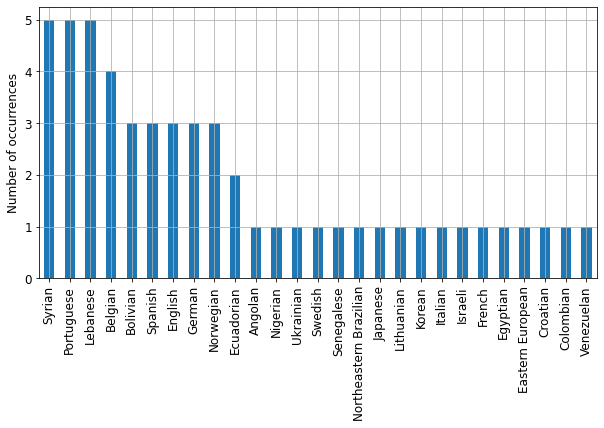

In [140]:
notContemplated = []

for i in np.arange(rest_compatibility_df.shape[0]):
    notContemplated = notContemplated + rest_compatibility_df['Restaurants not contemplated'][i].split(', ')

notContemplated = [rest for rest in notContemplated if rest != '']

for i in range(len(notContemplated)):
    notContemplated[i] = notContemplated[i].replace(' Restaurant', '')

notContemplated_df = pd.DataFrame(notContemplated, columns=['Restaurants not contemplated'])
notContemplated_df['Count'] = 1

ax = notContemplated_df.groupby('Restaurants not contemplated').sum().sort_values('Count', ascending=False).plot(kind='bar', figsize=(10,5))
plt.xlabel('')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
ax.get_legend().remove()

plt.show()

***
## Cluster neighborhoods according to restaurants

In [29]:
kclusters = 5 # set number of clusters

SP_clustering = SP_onehot_grouped.drop('Neighborhood', 1)

kmeans = sklearn.cluster.KMeans(n_clusters=kclusters, n_init=50).fit(SP_clustering) # run k-means clustering

# check cluster labels generated for each row in the dataframe
print('There are %d neighborhoods and %d labels:' % (SP_onehot_grouped.shape[0], kclusters))
for label in list(set(kmeans.labels_)):
    print('The label %d was applied to %.2f%% of the neighborhoods' % (label, 100*sum(kmeans.labels_ == label)/len(kmeans.labels_)))

There are 31 neighborhoods and 5 labels:
The label 0 was applied to 45.16% of the neighborhoods
The label 1 was applied to 3.23% of the neighborhoods
The label 2 was applied to 22.58% of the neighborhoods
The label 3 was applied to 25.81% of the neighborhoods
The label 4 was applied to 3.23% of the neighborhoods


In [27]:
SP_merged_cluster = SP_merged.copy()
SP_merged_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

map_SP_clusters = folium.Map(
    location=[
        geoData.latitude,
        geoData.longitude
    ], 
    zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, label, cluster in zip(SP_merged_cluster['Latitude'], 
                                    SP_merged_cluster['Longitude'], 
                                    '<b>' + SP_merged_cluster['Neighborhood'] + '</b>' + '\n\nImmigrants from: ' + SP_merged_cluster['Origin'],
                                    SP_merged_cluster['Cluster Labels']
                                   ):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=normalize('NFKD', label).encode('ASCII', 'ignore').decode('ASCII'),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_SP_clusters)

display(map_SP_clusters)